# Construction d'une visualisation en spirale du nombre de cas COVID-19

Beaucoup de visualisations en spirale ont été diffusées sur l'épidémie de COVID-19. Cependant, sauf erreur, ces visualisations sont produites uniquement en R. Ainsi, il y a ici un beau tutoriel visant à reproduire une visualisation du New York Time : https://bydata.github.io/nyt-corona-spiral-chart/

De telles illustrations sont anciennes, en témoigne les représentations de W.E.B. Du Bois, par ailleurs reproduites par Baptiste Coulmont : https://coulmont.com/blog/2020/12/11/la-spirale-de-du-bois/. 

Il a d'ailleurs produit de belles visualisations circulaires du nombre de décès : https://twitter.com/coulmont/status/1360545213144592385?s=20

**Essayons de le faire en Python !**

Charger les bibliothèques dont nous aurons besoin

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Désactiver les warnings...
import warnings
warnings.filterwarnings("ignore")

Charger les données de Our World In Data, à partir d'un CSV disponible sur un dépôt public

In [3]:
url = "https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv?raw=true"
data = pd.read_csv(url)
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Le travail le plus important d'une visualisation de données est le **traitement avant à la visualisation** proprement dite, et les étapes de modifications du jeu de données.

Dans notre cas, il faut :

1. regarder comment construire une visualisation polaire
2. trouver la manière de passer des dates à un angle allant de 0 à 360° (exprimé en radian)
3. trouver la manière d'encoder l'information du nombre de bas

Pour 1., petite recherche pour polarplot : https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_demo.html

Le plus simple est de copier le code et de comprendre comme il fonctionne. Matplotlib permet de faire beaucoup de choses.

Pour 2., on va transformer nos données pour :

- remplacer les valeurs manquantes par 0
- identifier les dates comme des objets dates pour extraire les informations utiles
- rajouter deux colonnes dans notre DataFrame : numéro du jour à partir du premier de l'année, et année

In [4]:
# Valeurs manquantes
data[["new_cases", "new_cases_smoothed"]] = data[["new_cases", "new_cases_smoothed"]].fillna(0)
# Mettre en format "date"
data["date"] = pd.to_datetime(data["date"])
# Utiliser des méthodes de l'objet date de Pandas pour créer de nouvelles colonnes
data["dayofyear"] = data["date"].dt.dayofyear # j'ai cherché comment faire dayofyear et il se trouve qu'il y a une fonction
data["year"] = data["date"].dt.year

Maintenant il s'agit de savoir comment représenter chaque valeur par un couple angle/rayon. Comme le montre le cas en R, l'idée est la suivante :

- construire une spirale de référence (l'ossature)
- ensuite ajouter la valeur des cas à partir de cette référence

La spirale de référence part du point 0,0 et l'angle varie progressivement ainsi que le rayon. 
- Pour l'angle, il faut que la spirale fasse un tour en un an, donc l'angle peut s'obtenir facilement par le jour avec la formule $\theta = 2*\pi*\frac{jour}{365}$
- Mais de combien à combien doit varier le rayon ? Une bonne estimation est qu'il faudra pouvoir représenter le nombre de cas, donc peut-être prendre comme ordre de grandeur le nombre de cas max. Il doit augmenter progressivement avec l'angle. Sauf que comme l'angle passe à 0 à chaque tour, il faut incrémenter aussi en fonction du nombre d'années. On a donc une proposition qui est : $r = K*(\theta + 2*\pi*(année - 2020))$ avec K notre constante d'ajustement de la taille

On va travailler sur un unique pays

In [26]:
df = data[data["location"]=="France"]
K = 2*df["new_cases_smoothed"].max()

In [27]:
df["dayofyear_angle"] = df["dayofyear"]*2 * np.pi/365 # gérer plus finement l'année bissextile
df["r_baseline"] = df.apply(lambda x : ((x["year"]-2020)*2 * np.pi + x["dayofyear_angle"])*K,axis=1)

On peut donc pour le moment tracer l'ossature de la visualisation pour un pays, la France

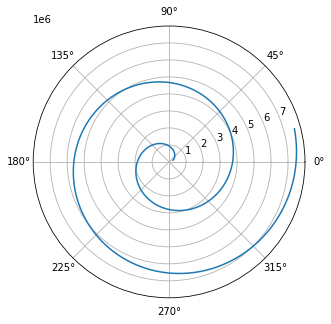

In [28]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(5,5))
ax.plot(df["dayofyear_angle"], df["r_baseline"])

Maintenant on va rajouter l'information du nombre de cas : pour cela on crée une nouvelle colonne de données qui comprend le nombre de cas + la référence qui évolue progressivement (le trait en bleu). Et on le fait de manière symétique pour avoir un bandeau.

En essayant on remarque aussi qu'il est intéressant de rajouter un coefficient d'expansion pour plus de lisibilité, appelé $E$

In [29]:
E = 8 # facteur d'expansion des données
df["r_cas_sup"] = df.apply(lambda x : x["r_baseline"] + E*x["new_cases_smoothed"],axis=1)
df["r_cas_inf"] = df.apply(lambda x : x["r_baseline"] - E*x["new_cases_smoothed"],axis=1)

Et on peut visualiser

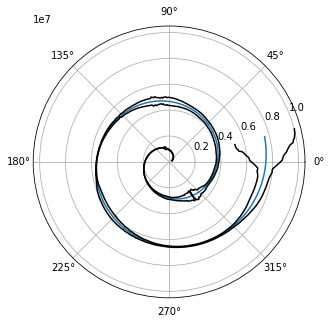

In [30]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(5,5))
ax.plot(df["dayofyear_angle"], df["r_baseline"])
ax.plot(df["dayofyear_angle"], df["r_cas_sup"],color="black")
ax.plot(df["dayofyear_angle"], df["r_cas_inf"],color="black")


Et peut-être remplir la zone entre les courbes

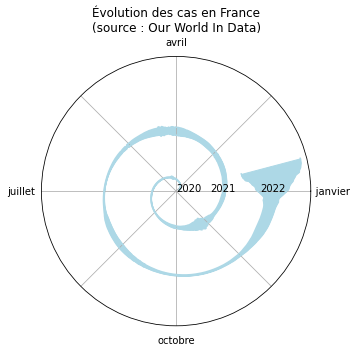

In [31]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(5,5))
ax.plot(df["dayofyear_angle"], df["r_cas_sup"],color="lightblue")
ax.plot(df["dayofyear_angle"], df["r_cas_inf"],color="lightblue")

ax.fill_between(df["dayofyear_angle"],df["r_baseline"], df["r_cas_sup"],color="lightblue")
ax.fill_between(df["dayofyear_angle"],df["r_baseline"], df["r_cas_inf"],color="lightblue")

ax.set_rticks([])
ax.grid(True)
ax.set_xticklabels(['     janvier', '', 'avril', '', 'juillet    ', '', 'octobre', ''])
plt.title("Évolution des cas en France\n(source : Our World In Data)")

# Quelques annotations
ax.annotate('2020',xy=(0, 0))
ax.annotate('2021',xy=(0, 4.5*K))
ax.annotate('2022',xy=(0, 11*K))

# Sauvegarder
plt.tight_layout()
plt.savefig("polar-covid-case-fr.png",dpi=400)

Bien sûr il y a encore beaucoup d'améliorations possibles ... mais bon, comme toujours, s'il faut attendre d'avoir tout traité, rien ne se fait.